<a href="https://colab.research.google.com/github/98RAMISLU/Basic_Portfolio/blob/main/fakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip -q install --upgrade transformers datasets evaluate scikit-learn pandas numpy shap lime torch fastapi uvicorn nest_asyncio pyngrok wordcloud jinja2

import os, re, random, json, time, threading, socket
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)

from wordcloud import WordCloud, STOPWORDS
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding,
    Trainer, TrainingArguments, pipeline
)

# Make output folder
OUTPUT_DIR = "/content/drive/MyDrive/Dissertation/outputs"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass

print("Torch device:", device)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 79.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but

In [ ]:
# Defining file paths
FAKE_PATH = "/content/drive/MyDrive/Dissertation/News _dataset/Fake.csv"
TRUE_PATH = "/content/drive/MyDrive/Dissertation/News _dataset/True.csv"


assert Path(FAKE_PATH).exists(), f"Missing: {FAKE_PATH}"
assert Path(TRUE_PATH).exists(), f"Missing: {TRUE_PATH}"

def clean_text(s: str) -> str:
    s = str(s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def extract_text(df: pd.DataFrame) -> pd.Series:
    cols = [c.lower() for c in df.columns]
    df.columns = cols
    if "text" in cols:
        txt = df["text"].fillna("")
    elif "content" in cols:
        txt = df["content"].fillna("")
    elif "article" in cols:
        txt = df["article"].fillna("")
    elif "title" in cols and "text" in cols:
        txt = (df["title"].fillna("") + ". " + df["text"].fillna(""))
    elif "title" in cols and "content" in cols:
        txt = (df["title"].fillna("") + ". " + df["content"].fillna(""))
    else:
        txt = df.apply(lambda r: " ".join([str(r[c]) for c in df.columns if pd.notnull(r[c])]), axis=1)
    return txt.astype(str)

df_fake = pd.read_csv(FAKE_PATH)
df_true = pd.read_csv(TRUE_PATH)

fake_text = extract_text(df_fake).apply(clean_text)
true_text = extract_text(df_true).apply(clean_text)

fake_df = pd.DataFrame({"text": fake_text, "label": 0})
true_df = pd.DataFrame({"text": true_text, "label": 1})

df = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)
df = df[df["text"].str.len() > 30].dropna().reset_index(drop=True)

print("Combined shape:", df.shape)
print(df["label"].value_counts().rename(index={0:"fake",1:"real"}))


Combined shape: (44192, 2)
label
fake    22776
real    21416
Name: count, dtype: int64


In [ ]:
df.head()

,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


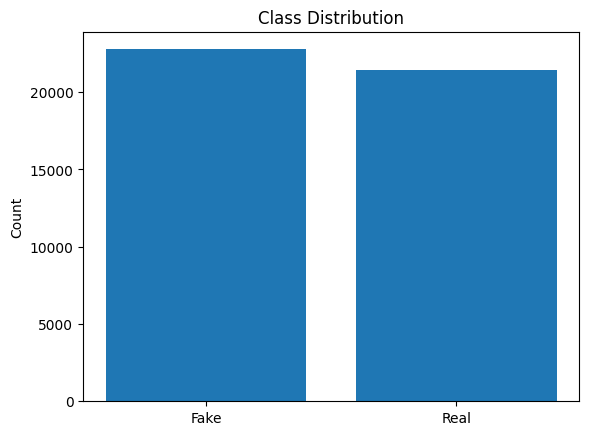

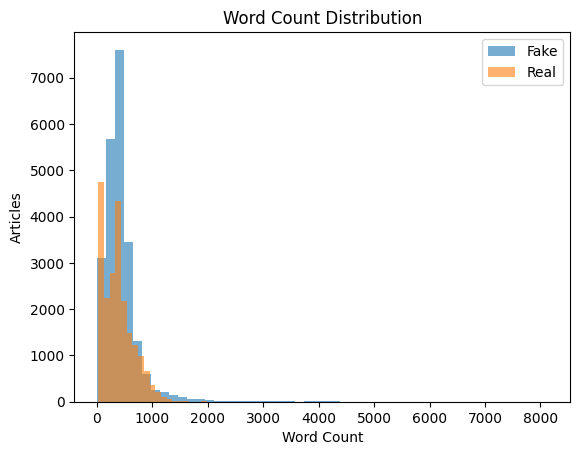

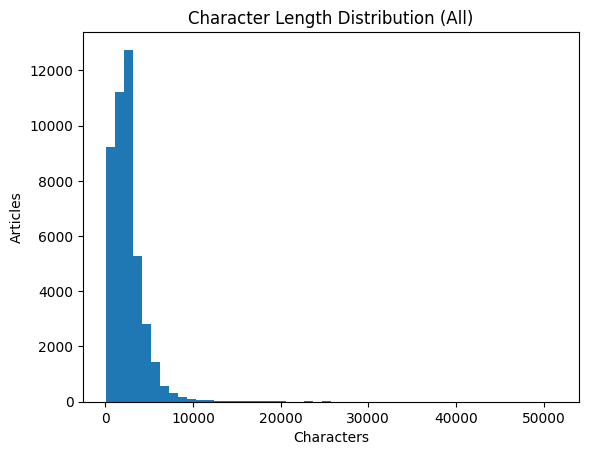

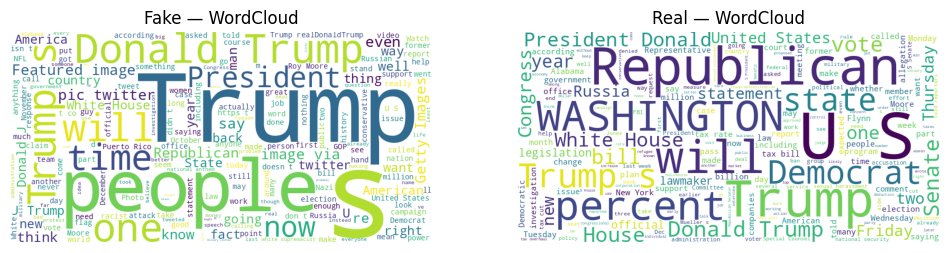

In [ ]:
#@title EDA Visualizations (matplotlib only)
# Class balance
counts = df["label"].value_counts().sort_index()
plt.figure()
plt.bar(["Fake", "Real"], counts)
plt.title("Class Distribution")
plt.ylabel("Count")
plt.show()

print('        ')
# Word counts
df["word_count"] = df["text"].apply(lambda x: len(x.split()))
fake_wc = df[df["label"]==0]["word_count"]
real_wc = df[df["label"]==1]["word_count"]

plt.figure()
plt.hist(fake_wc, bins=50, alpha=0.6, label="Fake")
plt.hist(real_wc, bins=50, alpha=0.6, label="Real")
plt.xlabel("Word Count"); plt.ylabel("Articles")
plt.title("Word Count Distribution")
plt.legend()
plt.show()
print('        ')

# Character lengths
df["char_len"] = df["text"].str.len()
plt.figure()
plt.hist(df["char_len"], bins=50)
plt.xlabel("Characters"); plt.ylabel("Articles")
plt.title("Character Length Distribution (All)")
plt.show()
print('        ')
# Word clouds
stopwords = set(STOPWORDS); stopwords.update(["said","reuters"])
try:
    wc_fake = WordCloud(width=800, height=400, stopwords=stopwords, background_color="white").generate(
        " ".join(df[df["label"]==0]["text"].tolist())[:1_000_000]
    )
    wc_real = WordCloud(width=800, height=400, stopwords=stopwords, background_color="white").generate(
        " ".join(df[df["label"]==1]["text"].tolist())[:1_000_000]
    )
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.imshow(wc_fake); plt.axis("off"); plt.title("Fake — WordCloud")
    plt.subplot(1,2,2); plt.imshow(wc_real); plt.axis("off"); plt.title("Real — WordCloud")
    plt.show()
except Exception as e:
    print("WordCloud error:", e)


In [ ]:
#@title Train/Val/Test split + tokenization
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df["label"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED, stratify=temp_df["label"])
print(f"Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")

BASE_MODEL = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True)

class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer, max_length=256):
        self.texts = df["text"].tolist()
        self.labels = df["label"].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer(self.texts[idx], truncation=True, padding=False, max_length=self.max_length)
        enc["labels"] = int(self.labels[idx])
        return {k: torch.tensor(v) for k,v in enc.items()}

MAX_LENGTH = 256
train_ds = NewsDataset(train_df, tokenizer, max_length=MAX_LENGTH)
val_ds   = NewsDataset(val_df, tokenizer, max_length=MAX_LENGTH)
test_ds  = NewsDataset(test_df, tokenizer, max_length=MAX_LENGTH)
collator = DataCollatorWithPadding(tokenizer=tokenizer)


Train=35353, Val=4419, Test=4420


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
#@title Init model & Trainer (with label maps)
from transformers import TrainingArguments, Trainer

id2label = {0:"fake",1:"real"}
label2id = {"fake":0,"real":1}

model = AutoModelForSequenceClassification.from_pretrained(
    BASE_MODEL, num_labels=2, id2label=id2label, label2id=label2id
)
model.to(device)

# Freeze encoder for faster baseline (set to False for better accuracy)
#freeze the Transformer encoder so its weights don’t change; only the tiny classifier layer learns.
FREEZE_ENCODER = True  #@param {type:"boolean"}
if FREEZE_ENCODER:
    for n, p in model.named_parameters():
        if not n.startswith("classifier"):
            p.requires_grad = False

training_args = TrainingArguments(
    output_dir="./outputs/checkpoints",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,
    learning_rate=3e-5 if FREEZE_ENCODER else 2e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_steps=50,
    logging_dir="./outputs/logs",
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
    report_to="none"
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    return {"accuracy":acc, "precision":p, "recall":r, "f1":f1}

# Quick-run toggle (sampled subset)
QUICK_RUN = True  #@param {type:"boolean"}
if QUICK_RUN:
    train_df_small = train_df.groupby("label", group_keys=False).apply(lambda x: x.sample(min(len(x), 500), random_state=SEED))
    val_df_small   = val_df.groupby("label", group_keys=False).apply(lambda x: x.sample(min(len(x), 200), random_state=SEED))
    train_ds = NewsDataset(train_df_small.reset_index(drop=True), tokenizer, max_length=MAX_LENGTH)
    val_ds   = NewsDataset(val_df_small.reset_index(drop=True), tokenizer, max_length=MAX_LENGTH)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=compute_metrics
)

trainer.train()

best_model_dir = os.path.join(OUTPUT_DIR, "best_model")
trainer.save_model(best_model_dir)
tokenizer.save_pretrained(best_model_dir)
print("Saved best model to:", best_model_dir)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3197314506.py:51: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df_small = train_df.groupby("label", group_keys=False).apply(lambda x: x.sample(min(len(x), 500), random_state=SEED))
/tmp/ipython-input-3197314506.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a fut

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.690400,0.686602,0.615000,0.755556,0.340000,0.468966
2,0.688000,0.683948,0.655000,0.798077,0.415000,0.546053
3,0.685300,0.683071,0.675000,0.807018,0.460000,0.585987


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Saved best model to: /content/drive/MyDrive/Dissertation/outputs/best_model


Accuracy=0.6975  Precision=0.7755  Recall=0.5289  F1=0.6289  ROC-AUC=0.7865  PR-AUC=0.7719

Classification report:
               precision    recall  f1-score   support

        Fake     0.6590    0.8560    0.7447      2278
        Real     0.7755    0.5289    0.6289      2142

    accuracy                         0.6975      4420
   macro avg     0.7173    0.6925    0.6868      4420
weighted avg     0.7155    0.6975    0.6886      4420



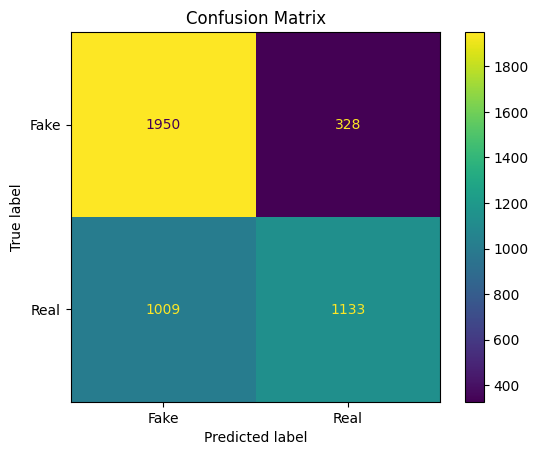

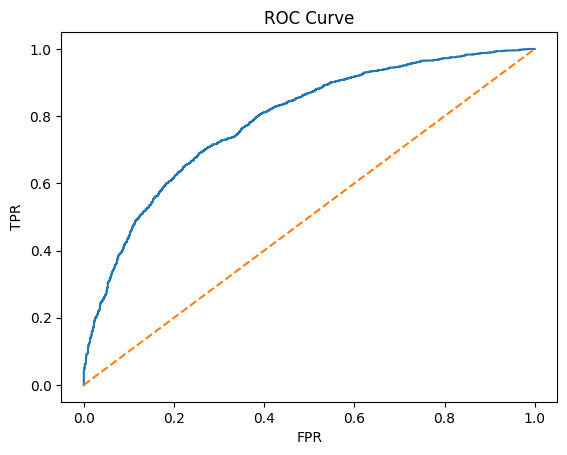

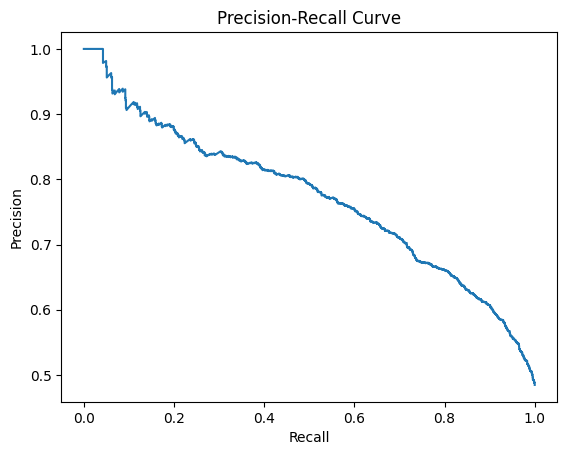

In [ ]:
#@title Evaluate on test set + plots
model = AutoModelForSequenceClassification.from_pretrained(best_model_dir).to(device)
tokenizer = AutoTokenizer.from_pretrained(best_model_dir)

enc = tokenizer(list(test_df["text"]), truncation=True, padding=True, max_length=MAX_LENGTH)
inputs = {k: torch.tensor(v) for k,v in enc.items()}

probs_all = []
with torch.no_grad():
    for i in range(0, len(test_df), 32):
        batch = {k: v[i:i+32].to(device) for k,v in inputs.items()}
        out = model(**batch)
        p = torch.softmax(out.logits, dim=1).cpu().numpy()
        probs_all.append(p)
probs = np.vstack(probs_all)

y_true = test_df["label"].values
y_pred = probs.argmax(axis=1)
p_real = probs[:,1]

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
auc = roc_auc_score(y_true, p_real)
ap = average_precision_score(y_true, p_real)
print(f"Accuracy={acc:.4f}  Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}  ROC-AUC={auc:.4f}  PR-AUC={ap:.4f}")

print("\nClassification report:\n", classification_report(y_true, y_pred, target_names=["Fake","Real"], digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake","Real"])
disp.plot(values_format="d")
plt.title("Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png", bbox_inches="tight")
plt.show()
print('                        ')

# ROC
fpr, tpr, _ = roc_curve(y_true, p_real)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC Curve")
plt.savefig(f"{OUTPUT_DIR}/roc_curve.png", bbox_inches="tight")
plt.show()
print('                        ')

# PR Curve
pr, rc, _ = precision_recall_curve(y_true, p_real)
plt.figure()
plt.plot(rc, pr)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.savefig(f"{OUTPUT_DIR}/pr_curve.png", bbox_inches="tight")
plt.show()


In [ ]:
#@title LIME explanation (saves HTML); SHAP optional demo
from lime.lime_text import LimeTextExplainer

clf = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    return_all_scores=True
)

def predict_fn(texts):
    if isinstance(texts, str): texts=[texts]
    outs = clf(texts, truncation=True)
    arr = []
    for out in outs:
        d = {o['label'].lower(): o['score'] for o in out}
        fake_p = float(d.get('fake', d.get('label_0', 0.0)))
        real_p = float(d.get('real', d.get('label_1', 0.0)))
        if fake_p==0 and real_p==0 and len(out)>=2:
            fake_p, real_p = out[0]['score'], out[1]['score']
        arr.append([fake_p, real_p])
    return np.array(arr, dtype=np.float32)

explainer = LimeTextExplainer(class_names=["fake","real"], split_expression=r"[A-Za-z0-9]{2,}", random_state=42)

sample_text = test_df.iloc[0]["text"][:1200]
exp = explainer.explain_instance(sample_text, classifier_fn=predict_fn, num_features=10, num_samples=300)
html_path = f"{OUTPUT_DIR}/lime_explanation_sample.html"
exp.save_to_file(html_path)
print("Saved LIME HTML to:", html_path)

# Optional: SHAP small demo (comment out if slow)
# import shap
# try:
#     masker = shap.maskers.Text(tokenizer)
# except Exception:
#     masker = shap.maskers.Text(r"\\W+")
# explainer_shap = shap.Explainer(predict_fn, masker)
# sv = explainer_shap([sample_text])
# shap.plots.text(sv[0])


Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Saved LIME HTML to: /content/drive/MyDrive/Dissertation/outputs/lime_explanation_sample.html


In [ ]:
#@title Build the HTML template (Tailwind UI)
templates_dir = Path("templates"); templates_dir.mkdir(exist_ok=True)

INDEX_HTML = """
<!doctype html>
<html lang="en">
  <head>
    <meta charset="utf-8" />
    <meta name="viewport" content="width=device-width, initial-scale=1" />
    <title>Real-Time Fake News Detector</title>
    <script src="https://cdn.tailwindcss.com"></script>
  </head>
  <body class="bg-gray-50 text-gray-900">
    <div class="max-w-5xl mx-auto p-6">
      <header class="mb-6">
        <h1 class="text-3xl font-bold">📰 Real-Time Fake News Detector</h1>
        <p class="text-gray-600">Transformer + Explainable AI (LIME)</p>
      </header>

      <form method="POST" action="/" class="mb-6">
        <div class="grid gap-4">
          <textarea name="text" rows="8" class="w-full rounded-xl border border-gray-300 p-4 shadow-sm focus:outline-none focus:ring-2 focus:ring-indigo-500" placeholder="Paste a news article here...">{{ text or '' }}</textarea>
          <div class="flex items-center gap-4">
            <label class="inline-flex items-center gap-2">
              <input type="checkbox" name="include_lime" class="w-4 h-4 rounded border-gray-300" checked>
              <span>Include LIME explanation</span>
            </label>
            <label class="flex items-center gap-2">
              <span class="text-sm text-gray-600">Top features:</span>
              <input type="number" name="lime_num_features" min="5" max="30" value="10" class="w-20 border rounded-lg p-1" />
            </label>
            <label class="flex items-center gap-2">
              <span class="text-sm text-gray-600">LIME samples:</span>
              <input type="number" name="lime_num_samples" min="100" max="2000" value="300" class="w-24 border rounded-lg p-1" />
            </label>
          </div>
          <button class="inline-flex items-center justify-center rounded-xl bg-indigo-600 px-5 py-2.5 font-medium text-white shadow hover:bg-indigo-700 transition">Analyze</button>
        </div>
      </form>

      {% if result %}
      <section class="bg-white rounded-2xl shadow p-6">
        <div class="flex items-center justify-between">
          <div class="flex items-center gap-3">
            {% if result.label == 'real' %}
              <span class="inline-flex items-center rounded-full bg-green-100 px-3 py-1 text-green-700 font-semibold">REAL</span>
            {% else %}
              <span class="inline-flex items-center rounded-full bg-red-100 px-3 py-1 text-red-700 font-semibold">FAKE</span>
            {% endif %}
            <span class="text-gray-500">Confidence:</span>
            <span class="font-semibold">{{ '%.2f'| format(result.confidence * 100) }}%</span>
          </div>
        </div>

        <div class="mt-4 grid grid-cols-1 md:grid-cols-2 gap-4">
          <div class="border rounded-xl p-4">
            <h3 class="font-semibold mb-2">Scores</h3>
            <div class="space-y-2">
              <div>
                <div class="flex justify-between text-sm">
                  <span>Fake</span><span>{{ '%.3f'|format(result.scores.fake) }}</span>
                </div>
                <div class="w-full bg-gray-200 rounded h-2">
                  <div class="bg-red-500 h-2 rounded" style="width: {{ result.scores.fake * 100 }}%"></div>
                </div>
              </div>
              <div>
                <div class="flex justify-between text-sm">
                  <span>Real</span><span>{{ '%.3f'|format(result.scores.real) }}</span>
                </div>
                <div class="w-full bg-gray-200 rounded h-2">
                  <div class="bg-green-500 h-2 rounded" style="width: {{ result.scores.real * 100 }}%"></div>
                </div>
              </div>
            </div>
          </div>

          <div class="border rounded-xl p-4">
            <h3 class="font-semibold mb-2">Top Features (LIME)</h3>
            {% if result.lime_top_features %}
              <div class="flex flex-wrap gap-2">
                {% for f in result.lime_top_features %}
                  {% set w = f.weight %}
                  {% if w >= 0 %}
                    <span class="px-2.5 py-1 rounded-full bg-green-100 text-green-700 text-sm">{{ f.token }} ({{ '%.2f'|format(w) }})</span>
                  {% else %}
                    <span class="px-2.5 py-1 rounded-full bg-red-100 text-red-700 text-sm">{{ f.token }} ({{ '%.2f'|format(w) }})</span>
                  {% endif %}
                {% endfor %}
              </div>
              <div class="mt-3">
                <a href="{{ result.lime_html_url }}" target="_blank" class="text-indigo-600 hover:underline">Open interactive LIME explanation →</a>
              </div>
            {% else %}
              <p class="text-gray-500">
              Explanation unavailable</p>
            {% endif %}
          </div>
        </div>
      </section>
      {% endif %}

      <footer class="mt-10 text-sm text-gray-500">
        <p>Model: DistilBERT • Real-time inference with FastAPI • Explanations via LIME</p>
      </footer>
    </div>
  </body>
</html>
"""
(Path("templates/index.html")).write_text(INDEX_HTML, encoding="utf-8")
print("Wrote templates/index.html")


Wrote templates/index.html


In [ ]:
#@title Launch FastAPI server (local URL)
import nest_asyncio, uvicorn
from fastapi import FastAPI, Request
from fastapi.responses import HTMLResponse
from fastapi.staticfiles import StaticFiles
from fastapi.templating import Jinja2Templates
from pydantic import BaseModel
from lime.lime_text import LimeTextExplainer

nest_asyncio.apply()

# Recreate classifier pipeline (GPU if available)
clf_pipeline = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    return_all_scores=True
)

def predict_proba(texts):
    if isinstance(texts, str): texts=[texts]
    outs = clf_pipeline(texts, truncation=True)
    arr = []
    for out in outs:
        d = {o['label'].lower(): o['score'] for o in out}
        fake_p = float(d.get('fake', d.get('label_0', 0.0)))
        real_p = float(d.get('real', d.get('label_1', 0.0)))
        if fake_p==0 and real_p==0 and len(out)>=2:
            fake_p, real_p = out[0]['score'], out[1]['score']
        arr.append([fake_p, real_p])
    return np.array(arr, dtype=np.float32)

explainer = LimeTextExplainer(class_names=["fake","real"], split_expression=r"[A-Za-z0-9]{2,}", random_state=42)

def lime_top_features(text, num_features=10, num_samples=300, trim_chars=1200):
    t = (text or "")[:trim_chars] if trim_chars and trim_chars>0 else (text or "")
    exp = explainer.explain_instance(t, classifier_fn=predict_proba, num_features=num_features, num_samples=num_samples)
    html_path = f"{OUTPUT_DIR}/lime_explanation_api.html"
    exp.save_to_file(html_path)
    pairs = exp.as_list()
    feats = [{"token": w.strip(), "weight": float(wt)} for w, wt in pairs if w.strip()]
    feats = sorted(feats, key=lambda d: abs(d["weight"]), reverse=True)[:num_features]
    return feats, "/outputs/" + os.path.basename(html_path)

app = FastAPI(title="Real-Time Fake News Detector", version="1.0")
app.mount("/outputs", StaticFiles(directory="outputs"), name="outputs")
templates = Jinja2Templates(directory="templates")

class AnalyzeIn(BaseModel):
    text: str
    include_lime: bool = True
    lime_num_features: int = 10
    lime_num_samples: int = 300
    trim_chars: int = 1200

@app.get("/health")
def health():
    return {"status": "ok"}

@app.get("/", response_class=HTMLResponse)
def index(request: Request):
    return templates.TemplateResponse("index.html", {"request": request, "result": None})

@app.post("/", response_class=HTMLResponse)
async def analyze_form(request: Request):
    form = await request.form()
    text = form.get("text","")
    include_lime = form.get("include_lime") == "on"
    lime_num_features = int(form.get("lime_num_features", 10))
    lime_num_samples = int(form.get("lime_num_samples", 300))
    probs = predict_proba(text)
    fake_p, real_p = float(probs[0][0]), float(probs[0][1])
    label = "real" if real_p >= fake_p else "fake"
    res = {"label": label, "confidence": max(fake_p, real_p), "scores": {"fake": fake_p, "real": real_p}}
    if include_lime:
        feats, url = lime_top_features(text, lime_num_features, lime_num_samples)
        res["lime_top_features"] = feats
        res["lime_html_url"] = url
    return templates.TemplateResponse("index.html", {"request": request, "result": res, "text": text})

# Start uvicorn on a free port
port = 8000
s = socket.socket()
while True:
    try:
        s.bind(("0.0.0.0", port)); s.close(); break
    except OSError:
        port += 1

threading.Thread(target=lambda: uvicorn.run(app, host="0.0.0.0", port=port, log_level="info"), daemon=True).start()
time.sleep(2)
print(f"Local UI:  http://127.0.0.1:{port}/")
print(f"Swagger:   http://127.0.0.1:{port}/docs")
print(f"LIME HTML:  http://127.0.0.1:{port}/outputs/lime_explanation_api.html (after a request)")


Device set to use cpu
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
INFO:     Started server process [1581]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


Local UI:  http://127.0.0.1:8000/
Swagger:   http://127.0.0.1:8000/docs
LIME HTML:  http://127.0.0.1:8000/outputs/lime_explanation_api.html (after a request)


In [ ]:
#@title Optional: Expose via ngrok (public URL)
from pyngrok import ngrok

os.environ["NGROK_AUTH_TOKEN"] = "329vxsc1jIzwZb5AWmN81BRK61c_3gnMtuhPpvwFvZ51zQRnS"

if "NGROK_AUTH_TOKEN" in os.environ and os.environ["NGROK_AUTH_TOKEN"]:
    ngrok.set_auth_token(os.environ["NGROK_AUTH_TOKEN"])
    public_url = ngrok.connect(8000, "http")
    print("Public UI:", public_url, "/")
    print("Swagger:", public_url, "/docs")
    print("LIME HTML (after request):", public_url, "/outputs/lime_explanation_api.html")
else:
    print("Set os.environ['NGROK_AUTH_TOKEN']='<your-token>' and re-run this cell.")


Public UI: NgrokTunnel: "https://bf065b9bd138.ngrok-free.app" -> "http://localhost:8000" /
Swagger: NgrokTunnel: "https://bf065b9bd138.ngrok-free.app" -> "http://localhost:8000" /docs
LIME HTML (after request): NgrokTunnel: "https://bf065b9bd138.ngrok-free.app" -> "http://localhost:8000" /outputs/lime_explanation_api.html
